In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from matplotlib import rc
%matplotlib inline
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
from scipy.optimize import brentq

import scipy.integrate as integrate
from scipy.stats import expon #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon
from scipy.stats import pareto #https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pareto.html#scipy.stats.pareto

In [2]:
import src.Class_FiscRule as CFR

In [3]:
save_results_to = 'output/'

### Fiscal rule for financial sanctions (i.e. $\rho = \beta$ so sanctions are partially wasted)

Average deficit $\frac{g - T}{Y}$ for the Euro area pre 1998 is 4.91% over 1995 (7.33%), 1996 (4.36%) and 1997 (3.05%). (OECD data)

Average revenue over GDP $\frac{T}{Y}$ for the Euro area 40.8% over 1995-19987. (Eurostat (gov_10a_taxag))

Target is the average deficit $\frac{g - T}{T} = \frac{g - T}{Y} \frac{Y}{T} = \frac{0.0491}{0.408} = 0.12$.

Normalize $T = 1$ and target an average spending $g$ to $1.12$

In [4]:
omega = 1

theta_min = 1
theta_max = 4

lambda_exp = 3
#gamma = lambda_exp * theta_min + 1 # so that the mean of the Pareto and the exponential distributions are the same
gamma = 4

# Environments
    # Low present bias
beta = 0.8
FR_exp = CFR.FiscRule(omega = omega, dist = 'exponential', lambda_exp = lambda_exp, beta = beta, rho = 1, grid_min = theta_min, grid_max = theta_max)
FR_mixture = CFR.FiscRule(omega = omega, dist = 'mixture', gamma = gamma, lambda_exp = lambda_exp, a_mixture  = 0.375, beta = beta, rho = 1, grid_min = theta_min, grid_max = theta_max)
FR_truncmixture = CFR.FiscRule(omega = omega, dist = 'trunc_mixture', gamma = gamma, lambda_exp = lambda_exp, a_mixture  = 0.375, beta = beta, rho = 1, grid_min = theta_min, grid_max = theta_max, theta_bar = 4.1)
FR_cal = CFR.FiscRule(omega = omega, dist = 'pareto',       gamma = gamma, beta = beta, rho = 1, grid_min = theta_min, grid_max = theta_max)

    # Intermediate present bias
beta_h = 0.7
FR_high = CFR.FiscRule(omega = omega, dist = 'exponential',       gamma = gamma, beta = beta_h, rho = 1, grid_min = theta_min, grid_max = theta_max)
FR_1 = CFR.FiscRule(omega = omega, dist = 'pareto',       gamma = gamma, beta = beta_h, rho = 1, grid_min = theta_min, grid_max = theta_max)
FR_2 = CFR.FiscRule(omega = omega, dist = 'trunc_pareto', gamma = gamma, beta = beta_h, rho = 1, grid_min = theta_min, grid_max = theta_max, theta_bar = 4.1)    

In [5]:
print("{:.2f}".format(FR_exp.mean_deficit()), 'mean deficit per unit of revenue with exponentially distributed shocks')
print("{:.2f}".format(FR_cal.mean_deficit()), 'mean deficit per unit of revenue with Pareto distributed shocks')
print("{:.2f}".format(FR_mixture.mean_deficit()), 'mean deficit per unit of revenue with F_a distributed shocks')
print("{:.2f}".format(FR_truncmixture.mean_deficit()), 'mean deficit per unit of revenue with truncated F_a distributed shocks')

0.12 mean deficit per unit of revenue with exponentially distributed shocks
0.11 mean deficit per unit of revenue with Pareto distributed shocks
0.12 mean deficit per unit of revenue with F_a distributed shocks
0.12 mean deficit per unit of revenue with truncated F_a distributed shocks


In [6]:
print('cap on spending at', "{:.2f}".format(FR_exp.discretionary(FR_exp.theta_p(FR_exp.theta_bar))-1), 'of revenue')

cap on spending at 0.12 of revenue


In [7]:
print('cap on spending at', "{:.2f}".format((FR_exp.discretionary(FR_exp.theta_p(FR_exp.theta_bar))-1)*0.4546), 'of GDP')

cap on spending at 0.06 of GDP


In [8]:
print("{:.2f}".format(FR_exp.mean_fiscal_need()))
print("{:.2f}".format(FR_1.mean_fiscal_need()))
print("{:.2f}".format(FR_mixture.mean_fiscal_need()))
print("{:.2f}".format(FR_truncmixture.mean_fiscal_need()))

1.33
1.33
1.33
1.32


In [9]:
# thresholds
theta_p = FR_exp.theta_p(FR_exp.theta_bar)
theta_L = FR_exp.theta_L_exp()
theta_e = FR_mixture.theta_n()
theta_L_mix = FR_mixture.theta_L_mix()
theta_e_tmix = FR_truncmixture.theta_n()
theta_xp_tmix = FR_truncmixture.theta_xp(FR_truncmixture.theta_bar)
theta_x_1 = FR_1.theta_x()
theta_x_2 = FR_2.theta_x()
theta_xp_2 = FR_2.theta_xp(FR_2.theta_bar)
theta_star = FR_2.theta_star()

In [10]:
print("{:.2f}".format(theta_p), 'theta_p')
print("{:.2f}".format(theta_L), 'theta_L for exponential')
print("{:.2f}".format(theta_e), 'theta_e')
print("{:.2f}".format(theta_L_mix), 'theta_L for F_a')
print("{:.2f}".format(theta_e_tmix), 'theta_n')
print("{:.2f}".format(theta_xp_tmix), 'theta_xp with F_a')
print("{:.2f}".format(theta_x_1), 'theta_x with Pareto')
print("{:.2f}".format(theta_xp_2), 'theta_xp with truncated Pareto')
print("{:.2f}".format(theta_star), 'theta star with truncated Pareto')

1.33 theta_p
1.67 theta_L for exponential
1.33 theta_e
1.72 theta_L for F_a
1.32 theta_n
2.20 theta_xp with F_a
1.57 theta_x with Pareto
2.20 theta_xp with truncated Pareto
2.74 theta star with truncated Pareto


In [11]:
# Allocations
    # Exponential
discretionary_exp = FR_exp.discretionary_alloc()
state_contingent_exp = FR_exp.state_contingent_alloc()
costly_disc_exp = FR_exp.costly_disc_alloc()
discretionary_cap = FR_exp.disc_cap_alloc(np.inf)

    # F truncated weibull
discretionary_wei = FR_truncmixture.discretionary_alloc()
state_contingent_wei = FR_truncmixture.state_contingent_alloc()
costly_disc = FR_truncmixture.costly_disc_alloc()
disc_costlydisc_prohib = FR_truncmixture.disc_costlydisc_prohib() #FR_wei.disc_costlydisc_prohib()

    # F Weibull
discretionary_wei_n = FR_mixture.discretionary_alloc()
state_contingent_wei_n = FR_mixture.state_contingent_alloc()
costly_disc_n = FR_mixture.costly_disc_alloc()
disc_costlydisc_n = FR_mixture.disc_costlydisc()

    # Exponential
discretionary_exp_h = FR_high.discretionary_alloc()
state_contingent_exp_h = FR_high.state_contingent_alloc()
costly_disc_exp_h = FR_high.costly_disc_alloc()
tight_cap_h = FR_high.tight_cap_alloc()

    # Pareto
discretionary_1 = FR_1.discretionary_alloc()
state_contingent_1 = FR_1.state_contingent_alloc()
costly_disc_alloc_1 = FR_1.costly_disc_alloc()
exempt_costlydisc = FR_1.exempt_costlydisc()

    # Truncated Pareto
discretionary_2 = FR_2.discretionary_alloc()
state_contingent_2 = FR_2.state_contingent_alloc()
costly_disc_alloc_2 = FR_2.costly_disc_alloc()
exempt_costlydisc_prohib = FR_2.exempt_costlydisc_prohib()

In [12]:
# Thresholds for plots
theta_p = FR_exp.theta_p(FR_exp.theta_bar)
theta_L = FR_exp.theta_L_exp()
theta_e = FR_truncmixture.theta_n()
theta_L_mix = FR_mixture.theta_L_mix()
theta_xp_w = FR_truncmixture.theta_xp(FR_truncmixture.theta_bar)
theta_e_n = FR_mixture.theta_n()
theta_x_1 = FR_1.theta_x()
theta_x_2 = FR_2.theta_x()
theta_xp_2 = FR_2.theta_xp(FR_2.theta_bar)
theta_star = FR_2.theta_star()

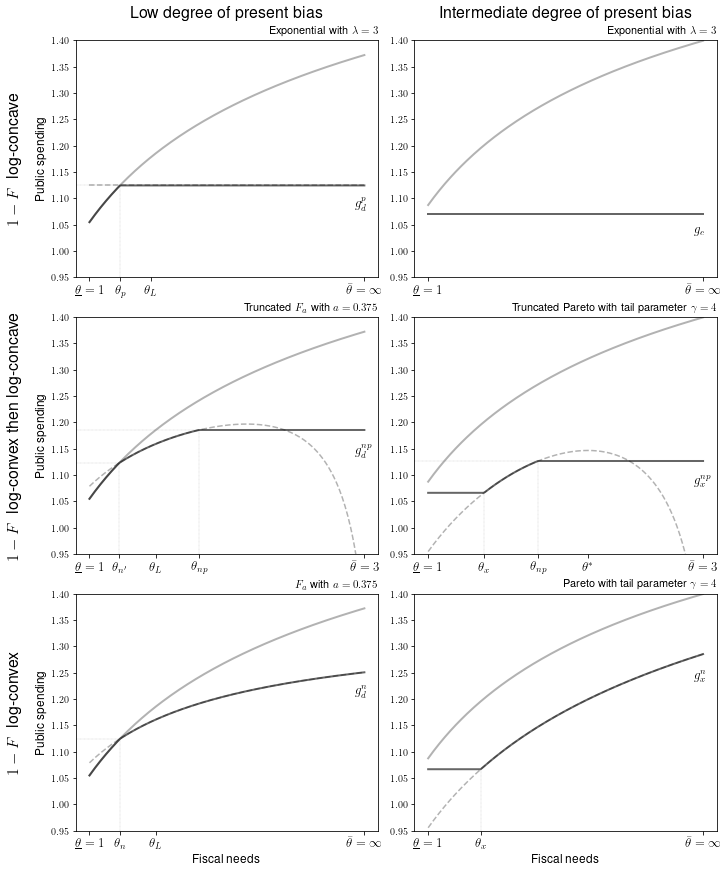

In [36]:
# Plot
fig, axarr = plt.subplot_mosaic([['a)','f)'],['b)', 'e)'],['c)', 'd)']], constrained_layout=True, figsize=(10,12))#, sharex=True, sharey=True)

axarr['a)'].plot(FR_exp.theta_grid, discretionary_exp, lw=2, alpha=0.6, linestyle='-',label='discretionary', color='gray')        
axarr['a)'].plot(FR_exp.theta_grid, costly_disc_exp, lw=1.5, alpha=0.6, linestyle='--', color='gray')
axarr['a)'].plot(FR_exp.theta_grid, discretionary_cap, lw=2, alpha=0.6, color='k', label='discretion and cap')

axarr['a)'].set_title('Exponential with $\\lambda = 3$', loc='right', fontsize=11)
axarr['a)'].set(xticks=[FR_exp.grid_min, theta_p, theta_L, theta_max])
axarr['a)'].set_xticklabels([r'$\underline{\theta}=1$', '$\\theta_p$', '$\\theta_{L}$', r'$\bar{\theta}=\infty$'], fontsize=13)


axarr['b)'].plot(FR_truncmixture.theta_grid, discretionary_wei, lw=2, alpha=0.6, linestyle='-', color='gray')
axarr['b)'].plot(FR_truncmixture.theta_grid, costly_disc, lw=1.5, alpha=0.6, linestyle='--', color='gray')
axarr['b)'].plot(FR_truncmixture.theta_grid, disc_costlydisc_prohib, lw=2, alpha=0.6, label='discretion, costly discretion and cap', linestyle='-', color='k')

axarr['b)'].set_title('Truncated $F_a$ with $a=0.375$', loc='right', fontsize=11)
axarr['b)'].set(xticks=[FR_truncmixture.grid_min, theta_e, theta_L_mix, theta_xp_w, theta_max])
axarr['b)'].set_xticklabels([r'$\underline{\theta}=1$', '$\\theta_{n\'}$', '$\\theta_{L}$', '$\\theta_{np}$', r'$\bar{\theta}=3$'], fontsize=13)

axarr['c)'].plot(FR_mixture.theta_grid, discretionary_wei_n, lw=2, alpha=0.6, linestyle='-',label='discretionary', color='gray')
axarr['c)'].plot(FR_mixture.theta_grid, costly_disc_n, lw=1.5, alpha=0.6, linestyle='--', color='gray')
axarr['c)'].plot(FR_mixture.theta_grid, disc_costlydisc_n, lw=2, alpha=0.6, label='discretion and costly discretion', linestyle='-', color='k')

axarr['c)'].set_title('$F_a$ with $a=0.375$', loc='right', fontsize=11)
axarr['c)'].set(xticks=[FR_mixture.grid_min, theta_e_n, theta_L_mix, theta_max])
axarr['c)'].set_xticklabels([r'$\underline{\theta}=1$', '$\\theta_n$', '$\\theta_{L}$', r'$\bar{\theta}=\infty$'], fontsize=13)

axarr['d)'].plot(FR_1.theta_grid, discretionary_1, lw=2, alpha=0.6, label='discretionary', linestyle='-', color='gray')
axarr['d)'].plot(FR_1.theta_grid, costly_disc_alloc_1, lw=1.5, alpha=0.6,label='costly discretion', linestyle='--', color='gray')
axarr['d)'].plot(FR_1.theta_grid, exempt_costlydisc, lw=2, alpha=0.6, label='exemption and costly discretion', color='k')
axarr['d)'].set(xticks=[FR_1.grid_min, theta_x_1, theta_max]) #yticks=[]
axarr['d)'].set_xticklabels([r'$\underline{\theta}=1$', '$\\theta_x$', r'$\bar{\theta}=\infty$'], fontsize=13)

axarr['d)'].set_title('Pareto with tail parameter $\\gamma = 4$', loc='right', fontsize=11)


axarr['f)'].plot(FR_high.theta_grid, discretionary_exp_h, lw=2, alpha=0.6, linestyle='-', color='gray')
axarr['f)'].plot(FR_high.theta_grid, tight_cap_h, lw=2, alpha=0.6, label='tight cap', color='k')
axarr['f)'].set(xticks=[FR_high.grid_min, theta_max])
axarr['f)'].set_xticklabels([r'$\underline{\theta}=1$',  r'$\bar{\theta}=\infty$'], fontsize=13)

axarr['f)'].set_title('Exponential with $\\lambda = 3$', loc='right', fontsize=11)


axarr['e)'].plot(FR_2.theta_grid, discretionary_2, lw=2, alpha=0.6, linestyle='-', color='gray')
axarr['e)'].plot(FR_2.theta_grid, costly_disc_alloc_2, lw=1.5, alpha=0.6, linestyle='--', color='gray')
axarr['e)'].plot(FR_2.theta_grid, exempt_costlydisc_prohib, lw=2, alpha=0.6, label='exemption, costly discretion and cap', color='k')
axarr['e)'].set(xticks=[FR_2.grid_min, theta_x_2, theta_xp_2, theta_star, theta_max])
axarr['e)'].set_xticklabels([r'$\underline{\theta}=1$', '$\\theta_x$', '$\\theta_{np}$', '$\\theta^*$', r'$\bar{\theta}=3$'], fontsize=13)

axarr['e)'].set_title('Truncated Pareto with tail parameter $\\gamma = 4$', loc='right', fontsize=11)

axarr['c)'].set_xlabel('Fiscal needs', fontsize=12)
axarr['d)'].set_xlabel('Fiscal needs', fontsize=12)
axarr['a)'].set_ylabel('Public spending', fontsize=12)
axarr['b)'].set_ylabel('Public spending', fontsize=12)
axarr['c)'].set_ylabel('Public spending', fontsize=12)

ymin=0.95
ymax=1.4
axarr['a)'].set_ylim([ymin,ymax])
axarr['b)'].set_ylim([ymin,ymax])
axarr['c)'].set_ylim([ymin,ymax])
axarr['d)'].set_ylim([ymin,ymax])
axarr['e)'].set_ylim([ymin,ymax])
axarr['f)'].set_ylim([ymin,ymax])

pad = 10
axarr['a)'].annotate('Low degree of present bias', xy=(0.5, 1.05), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points', 
                fontsize=16, ha='center', va='baseline')

axarr['f)'].annotate('Intermediate degree of present bias', xy=(0.5, 1.05), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=16, ha='center', va='baseline')

axarr['a)'].annotate('$1-F \ $ log-concave', xy=(0, 0.5), xytext=(-axarr['a)'].yaxis.labelpad - pad, 0),
                xycoords=axarr['a)'].yaxis.label, textcoords='offset points',
                fontsize=16, ha='right', va='center', rotation=90)

axarr['b)'].annotate('$1-F \ $ log-convex then log-concave', xy=(0, 0.5), xytext=(-axarr['b)'].yaxis.labelpad - pad, 0),
                xycoords=axarr['b)'].yaxis.label, textcoords='offset points',
                fontsize=16, ha='right', va='center', rotation=90)

axarr['c)'].annotate('$1-F \ $ log-convex', xy=(0, 0.5), xytext=(-axarr['c)'].yaxis.labelpad - pad, 0),
                xycoords=axarr['c)'].yaxis.label, textcoords='offset points',
                fontsize=16, ha='right', va='center', rotation=90)

axarr['a)'].axvline(x=theta_p, ymax=(FR_exp.discretionary(theta_p)-ymin)/(ymax-ymin), lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['a)'].axhline(y=FR_exp.discretionary(theta_p), xmax=0.14, lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['b)'].axvline(x=theta_e, ymax=(FR_truncmixture.discretionary(theta_e)-ymin)/(ymax-ymin), lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['b)'].axhline(y=FR_truncmixture.discretionary(theta_e), xmax=0.145, lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['b)'].axvline(x=theta_xp_w, ymax=(FR_truncmixture.costly_disc(theta_xp_w)-ymin)/(ymax-ymin), lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['b)'].axhline(y=FR_truncmixture.costly_disc(theta_xp_w), xmax=0.41, lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['c)'].axvline(x=theta_e_n , ymax=(FR_truncmixture.costly_disc(theta_e_n)-ymin)/(ymax-ymin), lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['c)'].axhline(y=FR_mixture.discretionary(theta_e_n), xmax=0.145, lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['d)'].axvline(x=theta_x_1, ymax=(FR_1.costly_disc(theta_x_1)-ymin)/(ymax-ymin), lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['e)'].axvline(x=theta_x_2, ymax=(FR_2.costly_disc(theta_x_2)-ymin)/(ymax-ymin), lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['e)'].axvline(x=theta_xp_2, ymax=(FR_2.costly_disc(theta_xp_2)-ymin)/(ymax-ymin), lw=0.3, alpha=0.6, color='k', linestyle=':')
axarr['e)'].axhline(y=FR_2.costly_disc(theta_xp_2), xmax=0.41, lw=0.3, alpha=0.6, color='k', linestyle=':')

axarr['a)'].text(3.9, 1.085, '$g_d^p$', fontsize=13)
axarr['b)'].text(3.9, 1.14, '$g_d^{np}$', fontsize=13)
axarr['c)'].text(3.9, 1.21, '$g_d^{n}$', fontsize=13)
axarr['d)'].text(3.9, 1.24, '$g_x^{n}$', fontsize=13)
axarr['e)'].text(3.9, 1.085, '$g_x^{np}$', fontsize=13)
axarr['f)'].text(3.9, 1.035, '$g_c$', fontsize=13)

#fig.suptitle('Optimal fiscal rule for an economic union with $\\rho = 1$', fontsize=16)
plt.savefig(save_results_to + 'Fig2_eu.pdf', dpi = 500)

plt.show()